# Creating the Gene Table
This notebook is copied from the [Pymodulon GitHub repository](https://github.com/SBRG/pymodulon/blob/master/docs/tutorials/creating_the_gene_table.ipynb)

In [1]:
pip install pymodulon

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pymodulon.gene_util import *
import os

## Get information from GFF files

First, download the FASTA and GFF files for your organism and its plasmids from NCBI.

Enter the location of all your GFF files here:

In [8]:
gff_files = os.path.join('..','data','sequence_file','genome.gff3')

The following cell will convert all the GFF files into a single Pandas DataFrame for easy manipulation. Pseudogenes have multiple rows in a GFF file (one for each fragment), but only the first fragment will be kept.

In [90]:
keep_cols = ['accession','start','end','strand','gene_name','old_locus_tag','gene_product','ncbi_protein']

DF_annot = gff2pandas(gff_files,index='locus_tag')
DF_annot = DF_annot[keep_cols]

DF_annot.head()

,accession,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein
locus_tag,,,,,,,,
WA5_RS00005,NC_020519.1,1,1575,+,dnaA,WA5_0001,chromosomal replication initiator protein DnaA,WP_011013309.1
WA5_RS00010,NC_020519.1,2292,3476,+,dnaN,WA5_0002,DNA polymerase III subunit beta,WP_003855336.1
WA5_RS00015,NC_020519.1,3585,4769,+,recF,WA5_0003,DNA replication/repair protein RecF,WP_011013310.1
WA5_RS00020,NC_020519.1,4766,5302,+,None,WA5_0004,DUF721 domain-containing protein,WP_003855338.1
WA5_RS00025,NC_020519.1,5435,7489,+,gyrB,WA5_0005,DNA topoisomerase (ATP-hydrolyzing) subunit B,WP_011013311.1


To ensure that the gene index used is identical to the expression matrix, load in your data.

In [91]:
log_tpm_file = os.path.join('..','data','log_tpm.csv')
DF_log_tpm = pd.read_csv(log_tpm_file,index_col=0)
DF_log_tpm.head()

,ERR1799216,ERR1799217,ERR1799218,ERR2401409,ERR2401410,ERR2401411,ERR2401412,ERR2401413,ERR2401414,ERR2601590,...,SRR7977566,SRR7977567,SRR7977568,SRR8170162,SRR8170163,SRR8170164,SRR8170165,SRR826828,SRR826829,SRR9841648
Geneid,,,,,,,,,,,,,,,,,,,,,
WA5_RS00005,6.748957,6.694018,6.656300,7.084559,6.904189,6.632775,6.773381,6.990737,5.979860,5.412320,...,6.972154,6.905722,6.963250,6.678815,6.820516,6.566540,6.512116,6.768705,6.800529,6.090916
WA5_RS00010,7.900443,8.148022,8.069989,8.121693,8.030589,8.357089,7.970764,7.824846,7.329225,7.790547,...,7.870916,7.867894,7.856385,7.598086,7.558333,7.424553,7.170096,7.502157,7.441951,7.729656
WA5_RS00015,6.175332,6.349828,6.232424,6.295537,6.257957,6.150341,5.834071,5.602574,5.004845,5.774210,...,6.183644,6.153692,6.018396,6.155190,6.281417,5.891608,5.677888,5.666250,5.868463,5.659856
WA5_RS00020,4.543705,4.635671,4.661486,5.088022,4.969515,5.568373,4.977782,5.196156,4.562569,4.613834,...,5.128698,5.189014,4.973984,5.115524,5.112433,5.053116,4.797296,4.917271,4.771606,4.223982
WA5_RS00025,9.246137,9.334762,9.323137,9.629883,9.599566,9.348087,9.036194,9.170387,8.348523,9.467890,...,9.480879,9.290066,9.435760,9.194899,9.194569,9.422188,9.388036,8.775972,8.861409,9.280935


Check that the genes are the same in the expression dataset as in the annotation dataframe. Mismatched genes are listed below.

In [92]:
test = DF_annot.sort_index().index == DF_log_tpm.sort_index().index
DF_annot[~test]

,accession,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein
locus_tag,,,,,,,,


## (Optional) KEGG and COGs

### Generate nucleotide fasta files for CDS

Enter the location of all your fasta files here:

In [93]:
fasta_files = os.path.join('..','data','sequence_file','genome.fasta')

The following code generates CDS files using your FASTA and GFF3 files

In [94]:
from Bio import SeqIO

cds_list = []
for fasta in fasta_files:
    seq = SeqIO.read(fasta,'fasta')

    # Get gene information for genes in this fasta file
    df_genes = DF_annot[DF_annot.accession == seq.id]
    
    for i,row in df_genes.iterrows():
        cds = seq[row.start-1:row.end]
        if row.strand == '-':
            cds = seq[row.start-1:row.end].reverse_complement()
        cds.id = row.name
        cds.description = row.gene_name if pd.notnull(row.gene_name) else row.name
        cds_list.append(cds)

In [95]:
cds_list[:5]

[SeqRecord(seq=Seq('GTGAGCCAGAACTCATCTTCTTTGCTCGAAACCTGGCGCCAAGTTGTTGCCGAT...TAA'), id='WA5_RS00005', name='NC_020519.1', description='dnaA', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGAGTCACAAAACGTGTCCTTCCGTGTGGCCAGGGAAGACCTGGTTACCGCG...TAA'), id='WA5_RS00010', name='NC_020519.1', description='dnaN', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGCACATCCGTTCTTTGGAATTACGTGATTACCGTTCCTGGCCTGAACTCAAA...TGA'), id='WA5_RS00015', name='NC_020519.1', description='recF', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGACAGATCCAATTGAGCAGGCATTTGAACGCATCCGCGCCGAAGCCATGCGC...TAG'), id='WA5_RS00020', name='NC_020519.1', description='WA5_RS00020', dbxrefs=[]),
 SeqRecord(seq=Seq('GTGGCAAACACTGAACACAATTATGACGCTTCATCGATCACCATCCTTGAAGGT...TAA'), id='WA5_RS00025', name='NC_020519.1', description='gyrB', dbxrefs=[])]

Save the CDS file

In [96]:
cds_file = os.path.join('..','data','cds.fna')
SeqIO.write(cds_list, cds_file, 'fasta')

3001

### Run EggNOG Mapper
1. Go to http://eggnog-mapper.embl.de/.
1. Upload the CDS.fna file from your organism directory (within the sequence_files folder)
1. Make sure to limit the taxonomy to the correct level
1. After the job is submitted, you must follow the link in your email to run the job.
1. Once the job completes (after ~4 hrs), download the annotations file.
1. Save the annotation file

### Get KEGG IDs

Once you have the EggNOG annotations, load the annotation file

In [97]:
eggnog_file = os.path.join('..','data','eggNOG_annotations.txt')

In [98]:
DF_eggnog = pd.read_csv(eggnog_file,sep='\t',skiprows=4,header=None)
eggnog_cols = ['query','seed_ortholog','evalue','score',
               'eggNOG_OGs','max_annot_lvl','COG_category',
               'Description','Preferred_name','GOs','EC','KEGG_orth',
               'KEGG_Pathway','KEGG_Module','KEGG_Reaction','KEGG_rclass','BRITE','KEGG_TC',
               'CAZy','BiGG_Reaction','PFAMs']

DF_eggnog.columns = eggnog_cols

# Strip last three rows as they are comments
DF_eggnog = DF_eggnog.iloc[:-3]

# Set locus tag as index
DF_eggnog = DF_eggnog.set_index('query')
DF_eggnog.index.name = 'locus_tag'

DF_eggnog.head()

,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,COG_category,Description,Preferred_name,GOs,EC,KEGG_orth,KEGG_Pathway,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs
locus_tag,,,,,,,,,,,,,,,,,,,,
WA5_RS00005,196627.cg0001,0.000000e+00,998.0,"COG0593@1|root,COG0593@2|Bacteria,2GJKI@201174...",201174|Actinobacteria,L,it binds specifically double-stranded DNA at a...,dnaA,"GO:0000166,GO:0003674,GO:0003676,GO:0003677,GO...",-,ko:K02313,"ko02020,ko04112,map02020,map04112",-,-,-,"ko00000,ko00001,ko03032,ko03036",-,-,-,"Bac_DnaA,Bac_DnaA_C"
WA5_RS00010,196627.cg0004,5.280000e-282,771.0,"COG0592@1|root,COG0592@2|Bacteria,2GJK3@201174...",201174|Actinobacteria,L,Confers DNA tethering and processivity to DNA ...,dnaN,"GO:0005575,GO:0005576,GO:0005618,GO:0005623,GO...",2.7.7.7,ko:K02338,"ko00230,ko00240,ko01100,ko03030,ko03430,ko0344...",M00260,"R00375,R00376,R00377,R00378",RC02795,"ko00000,ko00001,ko00002,ko01000,ko03032,ko03400",-,-,-,"DNA_pol3_beta,DNA_pol3_beta_2,DNA_pol3_beta_3"
WA5_RS00015,196627.cg0005,2.060000e-279,764.0,"COG1195@1|root,COG1195@2|Bacteria,2GJCS@201174...",201174|Actinobacteria,L,it is required for DNA replication and normal ...,recF,"GO:0000731,GO:0005575,GO:0005622,GO:0005623,GO...",-,ko:K03629,"ko03440,map03440",-,-,-,"ko00000,ko00001,ko03400",-,-,-,SMC_N
WA5_RS00020,196627.cg0006,2.310000e-127,362.0,"COG5512@1|root,COG5512@2|Bacteria,2GNQ4@201174...",201174|Actinobacteria,S,"Zn-ribbon-containing, possibly RNA-binding pro...",-,-,-,-,-,-,-,-,-,-,-,-,DUF721
WA5_RS00025,196627.cg0007,0.000000e+00,1348.0,"COG0187@1|root,COG0187@2|Bacteria,2GKGP@201174...",201174|Actinobacteria,L,A type II topoisomerase that negatively superc...,gyrB,"GO:0003674,GO:0003824,GO:0003916,GO:0003918,GO...",5.99.1.3,ko:K02470,-,-,-,-,"ko00000,ko01000,ko03032,ko03400",-,-,-,"DNA_gyraseB,DNA_gyraseB_C,HATPase_c,Toprim"


Now we will pull the KEGG information from the eggNOG file, including orthology, pathway, module, and reactions for each gene.

In [ ]:
DF_kegg = DF_eggnog[['KEGG_orth','KEGG_Pathway','KEGG_Module','KEGG_Reaction']]

# Melt dataframe
DF_kegg = DF_kegg.reset_index().melt(id_vars='locus_tag') 

# Remove null values
# DF_kegg = DF_kegg[DF_kegg.value.notnull()]
DF_kegg = DF_kegg[DF_kegg.value!='-']
# Split comma-separated values into their own rows
list2struct = []
for name,row in DF_kegg.iterrows():
    for val in row.value.split(','):
        list2struct.append([row.locus_tag,row.variable,val])
        print(val)

DF_kegg = pd.DataFrame(list2struct,columns=['gene_id','database','kegg_id'])

# Remove ko entries, as only map entries are searchable in KEGG pathway
DF_kegg = DF_kegg[~DF_kegg.kegg_id.str.startswith('ko')]

DF_kegg.head()

### Save KEGG information

In [100]:
DF_kegg.to_csv(os.path.join('..','data','kegg_mapping.csv'))

### Save COGs to annotation dataframe

In [101]:
DF_annot['COG'] = DF_eggnog.COG_category

# Make sure COG only has one entry per gene
DF_annot['COG'] = [item[0] if isinstance(item,str) else item for item in DF_annot['COG']]
DF_annot

,accession,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein,COG
locus_tag,,,,,,,,,
WA5_RS00005,NC_020519.1,1,1575,+,dnaA,WA5_0001,chromosomal replication initiator protein DnaA,WP_011013309.1,L
WA5_RS00010,NC_020519.1,2292,3476,+,dnaN,WA5_0002,DNA polymerase III subunit beta,WP_003855336.1,L
WA5_RS00015,NC_020519.1,3585,4769,+,recF,WA5_0003,DNA replication/repair protein RecF,WP_011013310.1,L
WA5_RS00020,NC_020519.1,4766,5302,+,None,WA5_0004,DUF721 domain-containing protein,WP_003855338.1,S
WA5_RS00025,NC_020519.1,5435,7489,+,gyrB,WA5_0005,DNA topoisomerase (ATP-hydrolyzing) subunit B,WP_011013311.1,L
...,...,...,...,...,...,...,...,...,...
WA5_RS15510,NC_020519.1,3305861,3306490,-,rsmG,WA5_2990,16S rRNA (guanine(527)-N(7))-methyltransferase...,WP_011266076.1,J
WA5_RS15515,NC_020519.1,3306679,3307632,-,yidC,WA5_2991,membrane protein insertase YidC,WP_003855313.1,U
WA5_RS15920,NC_020519.1,3307688,3307987,-,yidD,None,membrane protein insertion efficiency factor YidD,WP_011266077.1,S


## Uniprot ID mapping

The ``uniprot_id_mapping`` function is a python wrapper for the [Uniprot ID mapping tool](https://www.uniprot.org/uploadlists/). Use ``input_id=P_REFSEQ_AC`` if the FASTA/GFF files are from RefSeq, and ``input_id=EMBL`` if the files are from Genbank.

In [102]:
data4mapping = DF_annot.ncbi_protein
data4mapping.to_csv(os.path.join('..','data','data4mapping.txt',sep='\t',index=False,header=True)

In [103]:
mapping_uniprot = pd.read_excel(os.path.join('..','data','uniprot_mapping.xlsx'))

In [104]:
# Merge with current annotation
DF_annot = pd.merge(DF_annot.reset_index(),mapping_uniprot,how='left',on='ncbi_protein')
DF_annot.set_index('locus_tag',inplace=True)
DF_annot.head()

,accession,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein,COG,uniprot
locus_tag,,,,,,,,,,
WA5_RS00005,NC_020519.1,1,1575,+,dnaA,WA5_0001,chromosomal replication initiator protein DnaA,WP_011013309.1,L,A0A0U4QE26
WA5_RS00010,NC_020519.1,2292,3476,+,dnaN,WA5_0002,DNA polymerase III subunit beta,WP_003855336.1,L,A0A1B4WGU6
WA5_RS00015,NC_020519.1,3585,4769,+,recF,WA5_0003,DNA replication/repair protein RecF,WP_011013310.1,L,Q6M8X7
WA5_RS00020,NC_020519.1,4766,5302,+,None,WA5_0004,DUF721 domain-containing protein,WP_003855338.1,S,R0HV81
WA5_RS00025,NC_020519.1,5435,7489,+,gyrB,WA5_0005,DNA topoisomerase (ATP-hydrolyzing) subunit B,WP_011013311.1,L,A0A6L2RK64


## Add Biocyc Operon information

To obtain operon information from Biocyc, follow the steps below

1. Go to [Biocyc.org](https://biocyc.org/) (you may need to create an account and/or login)
2. Change the organism database to your organism/strain
3. Select **SmartTables** -> **Special SmartTables**
4. Select **"All genes of \<organism\>"**
5. Select the **"Gene Name"** column
6. Under **"ADD TRANSFORM COLUMN"** select **"Genes in same transcription unit"**
7. Select the **"Genes in same transcription unit"** column
8. Under **"ADD PROPERTY COLUMN"** select **"Accession-1"**
9. Under **OPERATIONS**, select **"Export"** -> **"to Spreadsheet File..."**
10. Select **"common names"** and click **"Export smarttable"**
11. Add file location below and run the code cell

In [105]:
biocyc_file = os.path.join('..','data','biocyc_annotations.txt')

DF_biocyc = pd.read_csv(biocyc_file,sep='\t')

# Remove genes with no accession
DF_biocyc = DF_biocyc[DF_biocyc['Accession-1'].notnull()]

# Set the accession (i.e. locus tag) as index
DF_biocyc = DF_biocyc.set_index('Accession-1').sort_values('Left-End-Position')

# Specific for B. subtilis: Fix locus tags
DF_biocyc.index = DF_biocyc.index.str.replace('BSU','BSU_')

# Only keep genes in the final annotation file
DF_biocyc = DF_biocyc.reindex(DF_annot.index)

# Reformat transcription units
DF_biocyc['operon_list'] = DF_biocyc['Accession-1.1'].apply(reformat_biocyc_tu)

# Fill None with locus tags
DF_biocyc['operon_list'].fillna(DF_biocyc.index.to_series(), inplace=True)

DF_biocyc.head()

,Gene Name,Left-End-Position,Right-End-Position,Product,Genes in same transcription unit,Accession-1.1,operon_list
locus_tag,,,,,,,
WA5_RS00005,dnaA,1.0,1575.0,chromosomal replication initiator protein DnaA,dnaN // dnaA,dnaN // dnaA,dnaA;dnaN
WA5_RS00010,dnaN,2292.0,3476.0,DNA polymerase III subunit beta,dnaN // dnaA,dnaN // dnaA,dnaA;dnaN
WA5_RS00015,recF,3585.0,4769.0,DNA replication/repair protein RecF,WA5_RS00020 // recF,WA5_RS00020 // recF,WA5_RS00020;recF
WA5_RS00020,WA5_RS00020,4766.0,5302.0,DUF721 domain-containing protein,WA5_RS00020 // recF,WA5_RS00020 // recF,WA5_RS00020;recF
WA5_RS00025,gyrB,5435.0,7489.0,DNA topoisomerase (ATP-hydrolyzing) subunit B,gyrB,WA5_RS00025,WA5_RS00025


### Assign unique IDs to operons

The following code assigns unique names to each operon

In [106]:
# Get all operons
operons = DF_biocyc['operon_list'].unique()

# Map each operon to a unique string
operon_dict = {operon: "Op"+str(i) for i, operon in enumerate(operons)}

# Add names to dataframe
DF_biocyc['operon'] = [operon_dict[op] for op in DF_biocyc["operon_list"]]

DF_biocyc

,Gene Name,Left-End-Position,Right-End-Position,Product,Genes in same transcription unit,Accession-1.1,operon_list,operon
locus_tag,,,,,,,,
WA5_RS00005,dnaA,1.0,1575.0,chromosomal replication initiator protein DnaA,dnaN // dnaA,dnaN // dnaA,dnaA;dnaN,Op0
WA5_RS00010,dnaN,2292.0,3476.0,DNA polymerase III subunit beta,dnaN // dnaA,dnaN // dnaA,dnaA;dnaN,Op0
WA5_RS00015,recF,3585.0,4769.0,DNA replication/repair protein RecF,WA5_RS00020 // recF,WA5_RS00020 // recF,WA5_RS00020;recF,Op1
WA5_RS00020,WA5_RS00020,4766.0,5302.0,DUF721 domain-containing protein,WA5_RS00020 // recF,WA5_RS00020 // recF,WA5_RS00020;recF,Op1
WA5_RS00025,gyrB,5435.0,7489.0,DNA topoisomerase (ATP-hydrolyzing) subunit B,gyrB,WA5_RS00025,WA5_RS00025,Op2
...,...,...,...,...,...,...,...,...
WA5_RS15510,rsmG,3305861.0,3306490.0,16S rRNA (guanine(527)-N(7))-methyltransferase...,rsmG,WA5_RS15510,WA5_RS15510,Op2003
WA5_RS15515,yidC,3306679.0,3307632.0,membrane protein insertase YidC,yidC,WA5_RS15515,WA5_RS15515,Op2004
WA5_RS15920,yidD,3307688.0,3307987.0,membrane protein insertion efficiency factor YidD,rpmH // rnpA // yidD,rpmH // rnpA // yidD,rnpA;rpmH;yidD,Op2005


Finally, merge the Biocyc information with the main annotation DataFrame

In [107]:
DF_annot['operon'] = DF_biocyc['operon']
DF_annot.head()

,accession,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein,COG,uniprot,operon
locus_tag,,,,,,,,,,,
WA5_RS00005,NC_020519.1,1,1575,+,dnaA,WA5_0001,chromosomal replication initiator protein DnaA,WP_011013309.1,L,A0A0U4QE26,Op0
WA5_RS00010,NC_020519.1,2292,3476,+,dnaN,WA5_0002,DNA polymerase III subunit beta,WP_003855336.1,L,A0A1B4WGU6,Op0
WA5_RS00015,NC_020519.1,3585,4769,+,recF,WA5_0003,DNA replication/repair protein RecF,WP_011013310.1,L,Q6M8X7,Op1
WA5_RS00020,NC_020519.1,4766,5302,+,None,WA5_0004,DUF721 domain-containing protein,WP_003855338.1,S,R0HV81,Op1
WA5_RS00025,NC_020519.1,5435,7489,+,gyrB,WA5_0005,DNA topoisomerase (ATP-hydrolyzing) subunit B,WP_011013311.1,L,A0A6L2RK64,Op2


## Clean up and save annotation

First, we will re-order the annotation columns

In [108]:
if 'old_locus_tag' in DF_annot.columns:
    order = ['gene_name','accession','old_locus_tag','start','end','strand','gene_product','COG','uniprot','operon']
else:
    order = ['gene_name','accession','start','end','strand','gene_product','COG','uniprot','operon']
    
DF_annot = DF_annot[order]

In [125]:
DF_annot.loc[DF_annot['COG'] == '-'] = None

## Final statistics

The following graphs show how much information is available for the organism.

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')

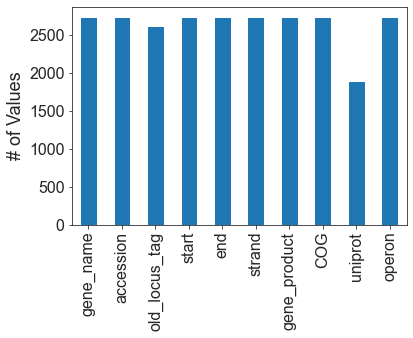

In [127]:
fig,ax = plt.subplots()
DF_annot.count().plot(kind='bar',ax=ax)
ax.set_ylabel('# of Values',fontsize=18)
ax.tick_params(labelsize=16)

## Fill missing values

Some organisms are missing gene names, so these will be filled with locus tag gene names.

In [128]:
# Fill in missing gene names with locus tag names
DF_annot['tmp_name'] = DF_annot.copy().index.tolist()
DF_annot.gene_name.fillna(DF_annot.tmp_name,inplace=True)
DF_annot.drop('tmp_name',axis=1,inplace=True)

 COG letters will also be converted to the full name.

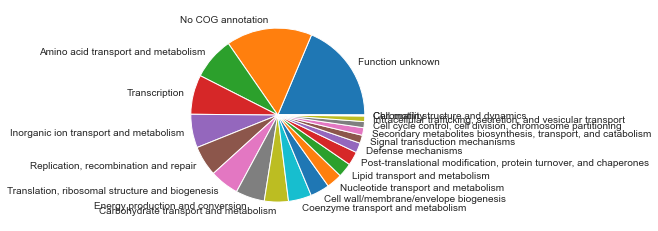

In [129]:
# Fill missing COGs with X
DF_annot['COG'].fillna('X',inplace=True)

# Change single letter COG annotation to full description
DF_annot['COG'] = DF_annot.COG.apply(cog2str)

counts = DF_annot.COG.value_counts()
plt.pie(counts.values,labels=counts.index)

Uncomment the following line to save the gene annotation dataset

In [134]:
DF_annot.to_csv(r'E:\test\gene_info.csv')

## GO Annotations

To start, download the GO Annotations for your organism from AmiGO 2

1. Go to [AmiGO 2](http://amigo.geneontology.org/amigo/search/annotation)
1. Filter for your organism
1. Click ``CustomDL``
1. Drag ``GO class (direct)`` to the end of your Selected Fields
1. Enter the location of your GO annotation file below and run the following code block

In [135]:
DF_GO = pd.read_csv(os.path.join('..','data','GO_annotations.txt',sep='\t',header=None,usecols=[2,17]))
DF_GO.columns = ['gene_name','gene_ontology']
DF_GO.head()

,gene_name,gene_ontology
0,gap,glyceraldehyde-3-phosphate dehydrogenase (NAD+...
1,gap,NAD binding
2,recA,SOS response
3,glpX,magnesium ion binding
4,glpX,manganese ion binding


Convert the gene names to gene locus tags, and drop gene names that cannot be converted

In [136]:
name2num = {v:k for k,v in DF_annot.gene_name.to_dict().items()}

In [137]:
DF_GO['gene_id'] = [name2num[x] if x in name2num.keys() else None for x in DF_GO.gene_name]

In [138]:
DF_GO.head()

,gene_name,gene_ontology,gene_id
0,gap,glyceraldehyde-3-phosphate dehydrogenase (NAD+...,WA5_RS07925
1,gap,NAD binding,WA5_RS07925
2,recA,SOS response,WA5_RS09740
3,glpX,magnesium ion binding,WA5_RS05070
4,glpX,manganese ion binding,WA5_RS05070


Now we remove null entries

In [139]:
DF_GO = DF_GO[DF_GO.gene_id.notnull()]

In [140]:
DF_GO.head()

,gene_name,gene_ontology,gene_id
0,gap,glyceraldehyde-3-phosphate dehydrogenase (NAD+...,WA5_RS07925
1,gap,NAD binding,WA5_RS07925
2,recA,SOS response,WA5_RS09740
3,glpX,magnesium ion binding,WA5_RS05070
4,glpX,manganese ion binding,WA5_RS05070


Uncomment the line below to save the annotations

In [141]:
DF_GO[['gene_id','gene_name','gene_ontology']].to_csv(os.path.join('..','data','GO_annotations_curated.csv'))